# `np_add_subtract_multiply_divide_i4`

In [1]:
from pynq import Overlay, allocate
import numpy as np

overlay = Overlay("/home/xilinx/jupyter_notebooks/np/overlays/np_add_subtract_multiply_divide_i4.bit")

L = 2**13

A = allocate(shape=(L,), dtype="i4")
B = allocate(shape=(L,), dtype="i4")
C = allocate(shape=(L,), dtype="i4")

A[:] = np.random.randint(1, 10_000, size=(L,))
B[:] = np.random.randint(1, 10_000, size=(L,))
C[:] = 0

## NumPy

In [2]:
def np_add_i4_numpy(x1, x2, out):
    np.add(x1, x2, out)

def np_subtract_i4_numpy(x1, x2, out):
    np.subtract(x1, x2, out)
    
def np_multiply_i4_numpy(x1, x2, out):
    np.multiply(x1, x2, out)

def np_divide_i4_numpy(x1, x2, out):
    np.floor_divide(x1, x2, out)

C[:] = 0
np_add_i4_numpy(A, B, C)
print(C)
np_subtract_i4_numpy(A, B, C)
print(C)
np_multiply_i4_numpy(A, B, C)
print(C)
np_divide_i4_numpy(A, B, C)
print(C)

[14118  7371  9673 ...  5972  7227  4481]
[ 3340  4103  7541 ...  2326 -3007 -3701]
[47040581  9374258  9175062 ...  7563627 10796870  1595490]
[1 3 8 ... 2 0 0]


## PYNQ

In [3]:
def np_add_i4_pynq(x1, x2, out):
    overlay.np_add_subtract_mult_0.mmio.write(0x10, x1.size)
    overlay.np_add_subtract_mult_0.mmio.write(0x18, 0x00)
    overlay.np_add_subtract_mult_0.mmio.write(0x0, 0x01)

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_1.sendchannel.transfer(x2)
    overlay.axi_dma_2.recvchannel.transfer(out)
    overlay.axi_dma_2.recvchannel.wait()

def np_subtract_i4_pynq(x1, x2, out):
    overlay.np_add_subtract_mult_0.mmio.write(0x10, x1.size)
    overlay.np_add_subtract_mult_0.mmio.write(0x18, 0x01)
    overlay.np_add_subtract_mult_0.mmio.write(0x0, 0x01)

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_1.sendchannel.transfer(x2)
    overlay.axi_dma_2.recvchannel.transfer(out)
    overlay.axi_dma_2.recvchannel.wait()

def np_multiply_i4_pynq(x1, x2, out):
    overlay.np_add_subtract_mult_0.mmio.write(0x10, x1.size)
    overlay.np_add_subtract_mult_0.mmio.write(0x18, 0x02)
    overlay.np_add_subtract_mult_0.mmio.write(0x0, 0x01)

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_1.sendchannel.transfer(x2)
    overlay.axi_dma_2.recvchannel.transfer(out)
    overlay.axi_dma_2.recvchannel.wait()

def np_divide_i4_pynq(x1, x2, out):
    overlay.np_add_subtract_mult_0.mmio.write(0x10, x1.size)
    overlay.np_add_subtract_mult_0.mmio.write(0x18, 0x03)
    overlay.np_add_subtract_mult_0.mmio.write(0x0, 0x01)

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_1.sendchannel.transfer(x2)
    overlay.axi_dma_2.recvchannel.transfer(out)
    overlay.axi_dma_2.recvchannel.wait()
    
C[:] = 0
np_add_i4_pynq(A, B, C)
print(C)
np_subtract_i4_pynq(A, B, C)
print(C)
np_multiply_i4_pynq(A, B, C)
print(C)
np_divide_i4_pynq(A, B, C)
print(C)

[14118  7371  9673 ...  5972  7227  4481]
[ 3340  4103  7541 ...  2326 -3007 -3701]
[47040581  9374258  9175062 ...  7563627 10796870  1595490]
[1 3 8 ... 2 0 0]


## pybind11

In [4]:
%%pybind11 np_add_subtract_multiply_divide_i4

#include <unistd.h>
#include <fcntl.h>
#include <termios.h>
#include <sys/mman.h>

#define MM2S_DMACR 0x00
#define MM2S_DMACR_RS 0x00000001
#define MM2S_DMACR_Reset 0x00000004
#define MM2S_DMASR 0x04
#define MM2S_DMASR_Halted 0x00000001
#define MM2S_DMASR_Idle 0x00000002
#define MM2S_SA 0x18
#define MM2S_SA_MSB 0x1c
#define MM2S_LENGTH 0x28

#define S2MM_DMACR 0x30
#define S2MM_DMACR_RS 0x00000001
#define S2MM_DMACR_Reset 0x00000004
#define S2MM_DMASR 0x34
#define S2MM_DMASR_Halted 0x00000001
#define S2MM_DMASR_Idle 0x00000002
#define S2MM_DA 0x48
#define S2MM_DA_MSB 0x4c
#define S2MM_LENGTH 0x58

#define printf py::print

#define DMA_0_ADDR 0x40400000
#define dma_0_get(x) DMA_0_VADDR[x >> 2]
#define dma_0_set(x, y) DMA_0_VADDR[x >> 2] = y

#define DMA_1_ADDR 0x40410000
#define dma_1_get(x) DMA_1_VADDR[x >> 2]
#define dma_1_set(x, y) DMA_1_VADDR[x >> 2] = y

#define DMA_2_ADDR 0x40420000
#define dma_2_get(x) DMA_2_VADDR[x >> 2]
#define dma_2_set(x, y) DMA_2_VADDR[x >> 2] = y

#define IP_ADDR 0x43C00000 
#define ip_set_stream_len(x) IP_VADDR[0x10 >> 2] = x
#define ip_set_sel(x) IP_VADDR[0x18 >> 2] = x
#define ip_start() IP_VADDR[0x00 >> 2] = 0x00000001

void np_add_i4(unsigned int x1_addr,
               unsigned int x2_addr,
               unsigned int out_addr,
               unsigned int stream_len)
{
    int fd = open("/dev/mem", O_RDWR | O_SYNC);
    volatile unsigned int * DMA_0_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
    );
    volatile unsigned int * DMA_1_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_1_ADDR
    );
    volatile unsigned int * DMA_2_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_2_ADDR
    );
    volatile unsigned int * IP_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, IP_ADDR
    );
    
    ip_set_stream_len(stream_len);
    ip_set_sel(0x00);
    ip_start();
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
    dma_1_set(S2MM_DMACR, S2MM_DMACR_Reset);
    dma_2_set(MM2S_DMACR, MM2S_DMACR_Reset);
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
    dma_1_set(S2MM_DMACR, S2MM_DMACR_RS);
    dma_2_set(MM2S_DMACR, MM2S_DMACR_RS);
    
    dma_0_set(MM2S_SA, x1_addr);
    dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));
    
    dma_1_set(MM2S_SA, x2_addr);
    dma_1_set(MM2S_LENGTH, stream_len * sizeof(float));
    
    dma_2_set(S2MM_DA, out_addr);
    dma_2_set(S2MM_LENGTH, stream_len * sizeof(float));
    
    while(!(dma_2_get(S2MM_DMASR) & S2MM_DMASR_Idle));
    
    close(fd);
}

void np_subtract_i4(unsigned int x1_addr,
                    unsigned int x2_addr,
                    unsigned int out_addr,
                    unsigned int stream_len)
{
    int fd = open("/dev/mem", O_RDWR | O_SYNC);
    volatile unsigned int * DMA_0_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
    );
    volatile unsigned int * DMA_1_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_1_ADDR
    );
    volatile unsigned int * DMA_2_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_2_ADDR
    );
    volatile unsigned int * IP_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, IP_ADDR
    );
    
    ip_set_stream_len(stream_len);
    ip_set_sel(0x01);
    ip_start();
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
    dma_1_set(S2MM_DMACR, S2MM_DMACR_Reset);
    dma_2_set(MM2S_DMACR, MM2S_DMACR_Reset);
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
    dma_1_set(S2MM_DMACR, S2MM_DMACR_RS);
    dma_2_set(MM2S_DMACR, MM2S_DMACR_RS);
    
    dma_0_set(MM2S_SA, x1_addr);
    dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));
    
    dma_1_set(MM2S_SA, x2_addr);
    dma_1_set(MM2S_LENGTH, stream_len * sizeof(float));
    
    dma_2_set(S2MM_DA, out_addr);
    dma_2_set(S2MM_LENGTH, stream_len * sizeof(float));
    
    while(!(dma_2_get(S2MM_DMASR) & S2MM_DMASR_Idle));
    
    close(fd);
}

void np_multiply_i4(unsigned int x1_addr,
                    unsigned int x2_addr,
                    unsigned int out_addr,
                    unsigned int stream_len)
{
    int fd = open("/dev/mem", O_RDWR | O_SYNC);
    volatile unsigned int * DMA_0_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
    );
    volatile unsigned int * DMA_1_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_1_ADDR
    );
    volatile unsigned int * DMA_2_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_2_ADDR
    );
    volatile unsigned int * IP_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, IP_ADDR
    );
    
    ip_set_stream_len(stream_len);
    ip_set_sel(0x02);
    ip_start();
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
    dma_1_set(S2MM_DMACR, S2MM_DMACR_Reset);
    dma_2_set(MM2S_DMACR, MM2S_DMACR_Reset);
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
    dma_1_set(S2MM_DMACR, S2MM_DMACR_RS);
    dma_2_set(MM2S_DMACR, MM2S_DMACR_RS);
    
    dma_0_set(MM2S_SA, x1_addr);
    dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));
    
    dma_1_set(MM2S_SA, x2_addr);
    dma_1_set(MM2S_LENGTH, stream_len * sizeof(float));
    
    dma_2_set(S2MM_DA, out_addr);
    dma_2_set(S2MM_LENGTH, stream_len * sizeof(float));
    
    while(!(dma_2_get(S2MM_DMASR) & S2MM_DMASR_Idle));
    
    close(fd);
}

void np_divide_i4(unsigned int x1_addr,
                  unsigned int x2_addr,
                  unsigned int out_addr,
                  unsigned int stream_len)
{
    int fd = open("/dev/mem", O_RDWR | O_SYNC);
    volatile unsigned int * DMA_0_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
    );
    volatile unsigned int * DMA_1_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_1_ADDR
    );
    volatile unsigned int * DMA_2_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_2_ADDR
    );
    volatile unsigned int * IP_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, IP_ADDR
    );
    
    ip_set_stream_len(stream_len);
    ip_set_sel(0x03);
    ip_start();
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
    dma_1_set(S2MM_DMACR, S2MM_DMACR_Reset);
    dma_2_set(MM2S_DMACR, MM2S_DMACR_Reset);
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
    dma_1_set(S2MM_DMACR, S2MM_DMACR_RS);
    dma_2_set(MM2S_DMACR, MM2S_DMACR_RS);
    
    dma_0_set(MM2S_SA, x1_addr);
    dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));
    
    dma_1_set(MM2S_SA, x2_addr);
    dma_1_set(MM2S_LENGTH, stream_len * sizeof(float));
    
    dma_2_set(S2MM_DA, out_addr);
    dma_2_set(S2MM_LENGTH, stream_len * sizeof(float));
    
    while(!(dma_2_get(S2MM_DMASR) & S2MM_DMASR_Idle));
    
    close(fd);
}

In [5]:
import np_add_subtract_multiply_divide_i4 as calc

def np_add_i4_pybind11(x1, x2, out):
    calc.np_add_i4(x1.physical_address, x2.physical_address, out.physical_address, x1.size)

def np_subtract_i4_pybind11(x1, x2, out):
    calc.np_subtract_i4(x1.physical_address, x2.physical_address, out.physical_address, x1.size)

def np_multiply_i4_pybind11(x1, x2, out):
    calc.np_multiply_i4(x1.physical_address, x2.physical_address, out.physical_address, x1.size)

def np_divide_i4_pybind11(x1, x2, out):
    calc.np_divide_i4(x1.physical_address, x2.physical_address, out.physical_address, x1.size)
    
C[:] = 0
np_add_i4_pybind11(A, B, C)
print(C)
np_subtract_i4_pybind11(A, B, C)
print(C)
np_multiply_i4_pybind11(A, B, C)
print(C)
np_divide_i4_pybind11(A, B, C)
print(C)

[14118  7371  9673 ...  5972  7227  4481]
[ 3340  4103  7541 ...  2326 -3007 -3701]
[47040581  9374258  9175062 ...  7563627 10796870  1595490]
[1 3 8 ... 2 0 0]


## CFFI

In [6]:
%%writefile build_np_add_subtract_multiply_divide_i4_cffi.py

from cffi import FFI
ffibuilder = FFI()

ffibuilder.cdef(
    r"""
    void np_add_i4(unsigned int x1_addr,
                   unsigned int x2_addr,
                   unsigned int out_addr,
                   unsigned int stream_len);
    void np_subtract_i4(unsigned int x1_addr,
                        unsigned int x2_addr,
                        unsigned int out_addr,
                        unsigned int stream_len);
    void np_multiply_i4(unsigned int x1_addr,
                        unsigned int x2_addr,
                        unsigned int out_addr,
                        unsigned int stream_len);
    void np_divide_i4(unsigned int x1_addr,
                      unsigned int x2_addr,
                      unsigned int out_addr,
                      unsigned int stream_len);
    """
)

ffibuilder.set_source("np_add_subtract_multiply_divide_i4_cffi",
    r"""
    #include <unistd.h>
    #include <fcntl.h>
    #include <termios.h>
    #include <sys/mman.h>

    #define MM2S_DMACR 0x00
    #define MM2S_DMACR_RS 0x00000001
    #define MM2S_DMACR_Reset 0x00000004
    #define MM2S_DMASR 0x04
    #define MM2S_DMASR_Halted 0x00000001
    #define MM2S_DMASR_Idle 0x00000002
    #define MM2S_SA 0x18
    #define MM2S_SA_MSB 0x1c
    #define MM2S_LENGTH 0x28

    #define S2MM_DMACR 0x30
    #define S2MM_DMACR_RS 0x00000001
    #define S2MM_DMACR_Reset 0x00000004
    #define S2MM_DMASR 0x34
    #define S2MM_DMASR_Halted 0x00000001
    #define S2MM_DMASR_Idle 0x00000002
    #define S2MM_DA 0x48
    #define S2MM_DA_MSB 0x4c
    #define S2MM_LENGTH 0x58

    #define printf py::print

    #define DMA_0_ADDR 0x40400000
    #define dma_0_get(x) DMA_0_VADDR[x >> 2]
    #define dma_0_set(x, y) DMA_0_VADDR[x >> 2] = y

    #define DMA_1_ADDR 0x40410000
    #define dma_1_get(x) DMA_1_VADDR[x >> 2]
    #define dma_1_set(x, y) DMA_1_VADDR[x >> 2] = y

    #define DMA_2_ADDR 0x40420000
    #define dma_2_get(x) DMA_2_VADDR[x >> 2]
    #define dma_2_set(x, y) DMA_2_VADDR[x >> 2] = y

    #define IP_ADDR 0x43C00000 
    #define ip_set_stream_len(x) IP_VADDR[0x10 >> 2] = x
    #define ip_set_sel(x) IP_VADDR[0x18 >> 2] = x
    #define ip_start() IP_VADDR[0x00 >> 2] = 0x00000001

    void np_add_i4(unsigned int x1_addr,
                   unsigned int x2_addr,
                   unsigned int out_addr,
                   unsigned int stream_len)
    {
        int fd = open("/dev/mem", O_RDWR | O_SYNC);
        volatile unsigned int * DMA_0_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
        );
        volatile unsigned int * DMA_1_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_1_ADDR
        );
        volatile unsigned int * DMA_2_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_2_ADDR
        );
        volatile unsigned int * IP_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, IP_ADDR
        );

        ip_set_stream_len(stream_len);
        ip_set_sel(0x00);
        ip_start();

        dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
        dma_1_set(S2MM_DMACR, S2MM_DMACR_Reset);
        dma_2_set(MM2S_DMACR, MM2S_DMACR_Reset);

        dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
        dma_1_set(S2MM_DMACR, S2MM_DMACR_RS);
        dma_2_set(MM2S_DMACR, MM2S_DMACR_RS);

        dma_0_set(MM2S_SA, x1_addr);
        dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));

        dma_1_set(MM2S_SA, x2_addr);
        dma_1_set(MM2S_LENGTH, stream_len * sizeof(float));

        dma_2_set(S2MM_DA, out_addr);
        dma_2_set(S2MM_LENGTH, stream_len * sizeof(float));

        while(!(dma_2_get(S2MM_DMASR) & S2MM_DMASR_Idle));

        close(fd);
    }

    void np_subtract_i4(unsigned int x1_addr,
                        unsigned int x2_addr,
                        unsigned int out_addr,
                        unsigned int stream_len)
    {
        int fd = open("/dev/mem", O_RDWR | O_SYNC);
        volatile unsigned int * DMA_0_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
        );
        volatile unsigned int * DMA_1_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_1_ADDR
        );
        volatile unsigned int * DMA_2_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_2_ADDR
        );
        volatile unsigned int * IP_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, IP_ADDR
        );

        ip_set_stream_len(stream_len);
        ip_set_sel(0x01);
        ip_start();

        dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
        dma_1_set(S2MM_DMACR, S2MM_DMACR_Reset);
        dma_2_set(MM2S_DMACR, MM2S_DMACR_Reset);

        dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
        dma_1_set(S2MM_DMACR, S2MM_DMACR_RS);
        dma_2_set(MM2S_DMACR, MM2S_DMACR_RS);

        dma_0_set(MM2S_SA, x1_addr);
        dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));

        dma_1_set(MM2S_SA, x2_addr);
        dma_1_set(MM2S_LENGTH, stream_len * sizeof(float));

        dma_2_set(S2MM_DA, out_addr);
        dma_2_set(S2MM_LENGTH, stream_len * sizeof(float));

        while(!(dma_2_get(S2MM_DMASR) & S2MM_DMASR_Idle));

        close(fd);
    }

    void np_multiply_i4(unsigned int x1_addr,
                        unsigned int x2_addr,
                        unsigned int out_addr,
                        unsigned int stream_len)
    {
        int fd = open("/dev/mem", O_RDWR | O_SYNC);
        volatile unsigned int * DMA_0_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
        );
        volatile unsigned int * DMA_1_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_1_ADDR
        );
        volatile unsigned int * DMA_2_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_2_ADDR
        );
        volatile unsigned int * IP_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, IP_ADDR
        );

        ip_set_stream_len(stream_len);
        ip_set_sel(0x02);
        ip_start();

        dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
        dma_1_set(S2MM_DMACR, S2MM_DMACR_Reset);
        dma_2_set(MM2S_DMACR, MM2S_DMACR_Reset);

        dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
        dma_1_set(S2MM_DMACR, S2MM_DMACR_RS);
        dma_2_set(MM2S_DMACR, MM2S_DMACR_RS);

        dma_0_set(MM2S_SA, x1_addr);
        dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));

        dma_1_set(MM2S_SA, x2_addr);
        dma_1_set(MM2S_LENGTH, stream_len * sizeof(float));

        dma_2_set(S2MM_DA, out_addr);
        dma_2_set(S2MM_LENGTH, stream_len * sizeof(float));

        while(!(dma_2_get(S2MM_DMASR) & S2MM_DMASR_Idle));

        close(fd);
    }

    void np_divide_i4(unsigned int x1_addr,
                      unsigned int x2_addr,
                      unsigned int out_addr,
                      unsigned int stream_len)
    {
        int fd = open("/dev/mem", O_RDWR | O_SYNC);
        volatile unsigned int * DMA_0_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
        );
        volatile unsigned int * DMA_1_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_1_ADDR
        );
        volatile unsigned int * DMA_2_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_2_ADDR
        );
        volatile unsigned int * IP_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, IP_ADDR
        );

        ip_set_stream_len(stream_len);
        ip_set_sel(0x03);
        ip_start();

        dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
        dma_1_set(S2MM_DMACR, S2MM_DMACR_Reset);
        dma_2_set(MM2S_DMACR, MM2S_DMACR_Reset);

        dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
        dma_1_set(S2MM_DMACR, S2MM_DMACR_RS);
        dma_2_set(MM2S_DMACR, MM2S_DMACR_RS);

        dma_0_set(MM2S_SA, x1_addr);
        dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));

        dma_1_set(MM2S_SA, x2_addr);
        dma_1_set(MM2S_LENGTH, stream_len * sizeof(float));

        dma_2_set(S2MM_DA, out_addr);
        dma_2_set(S2MM_LENGTH, stream_len * sizeof(float));

        while(!(dma_2_get(S2MM_DMASR) & S2MM_DMASR_Idle));

        close(fd);
    }
    """
)

if __name__ == "__main__":
    ffibuilder.compile(verbose=True)

Writing build_np_add_subtract_multiply_divide_i4_cffi.py


In [7]:
%%bash

/home/xilinx/perf_env/bin/python build_np_add_subtract_multiply_divide_i4_cffi.py

generating ./np_add_subtract_multiply_divide_i4_cffi.c
the current directory is '/home/xilinx/jupyter_notebooks/np/build'
running build_ext
building 'np_add_subtract_multiply_divide_i4_cffi' extension
arm-linux-gnueabihf-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/home/xilinx/perf_env/include -I/usr/include/python3.7m -c np_add_subtract_multiply_divide_i4_cffi.c -o ./np_add_subtract_multiply_divide_i4_cffi.o
arm-linux-gnueabihf-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 ./np_add_subtract_multiply_divide_i4_cffi.o -o ./np_add_subtract_multiply_divide_i4_cffi.cpython

In [8]:
from np_add_subtract_multiply_divide_i4_cffi import lib

def np_add_i4_cffi(x1, x2, out):
    lib.np_add_i4(x1.physical_address, x2.physical_address, out.physical_address, x1.size)

def np_subtract_i4_cffi(x1, x2, out):
    lib.np_subtract_i4(x1.physical_address, x2.physical_address, out.physical_address, x1.size)

def np_multiply_i4_cffi(x1, x2, out):
    lib.np_multiply_i4(x1.physical_address, x2.physical_address, out.physical_address, x1.size)

def np_divide_i4_cffi(x1, x2, out):
    lib.np_divide_i4(x1.physical_address, x2.physical_address, out.physical_address, x1.size)

C[:] = 0
np_add_i4_cffi(A, B, C)
print(C)
np_subtract_i4_cffi(A, B, C)
print(C)
np_multiply_i4_cffi(A, B, C)
print(C)
np_divide_i4_cffi(A, B, C)
print(C)

[14118  7371  9673 ...  5972  7227  4481]
[ 3340  4103  7541 ...  2326 -3007 -3701]
[47040581  9374258  9175062 ...  7563627 10796870  1595490]
[1 3 8 ... 2 0 0]


## Timing analysis

kernel = 0, n = 4, t = 8.514030000000001e-05
kernel = 1, n = 4, t = 0.1859405961
kernel = 2, n = 4, t = 0.00013581210000000003
kernel = 3, n = 4, t = 0.0001297649
kernel = 4, n = 4, t = 8.31409e-05
kernel = 5, n = 4, t = 0.1866693416
kernel = 6, n = 4, t = 0.0001339379
kernel = 7, n = 4, t = 0.00012986710000000002
kernel = 8, n = 4, t = 7.543360000000001e-05
kernel = 9, n = 4, t = 0.1850882102
kernel = 10, n = 4, t = 0.0001412304
kernel = 11, n = 4, t = 0.00014035300000000002
kernel = 12, n = 4, t = 0.0015623317000000002


/home/xilinx/perf_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in floor_divide
  # This is added back by InteractiveShellApp.init_path()


kernel = 13, n = 4, t = 0.18774907080000003
kernel = 14, n = 4, t = 0.000141812
kernel = 15, n = 4, t = 0.0005266538
kernel = 0, n = 8, t = 7.947610000000002e-05
kernel = 1, n = 8, t = 0.18483989150000002
kernel = 2, n = 8, t = 0.00013910350000000002
kernel = 3, n = 8, t = 0.00013354310000000003
kernel = 4, n = 8, t = 7.40909e-05
kernel = 5, n = 8, t = 0.198198797
kernel = 6, n = 8, t = 0.0001429034
kernel = 7, n = 8, t = 0.0001426985
kernel = 8, n = 8, t = 7.452250000000001e-05
kernel = 9, n = 8, t = 0.18541959060000002
kernel = 10, n = 8, t = 0.0001375133
kernel = 11, n = 8, t = 0.0005459523
kernel = 12, n = 8, t = 0.0001228376
kernel = 13, n = 8, t = 0.1848680386
kernel = 14, n = 8, t = 0.0001394982
kernel = 15, n = 8, t = 0.00013340160000000002
kernel = 0, n = 16, t = 7.528130000000001e-05
kernel = 1, n = 16, t = 0.1864845222
kernel = 2, n = 16, t = 0.0001382025
kernel = 3, n = 16, t = 0.00013613720000000003
kernel = 4, n = 16, t = 7.6968e-05
kernel = 5, n = 16, t = 0.1850484702
ke

kernel = 1, n = 32768, t = 0.1877897151
kernel = 2, n = 32768, t = 0.0004977462
kernel = 3, n = 32768, t = 0.0005897563000000001
kernel = 4, n = 32768, t = 0.012024537600000001
kernel = 5, n = 32768, t = 0.19989984900000002
kernel = 6, n = 32768, t = 0.0005046739000000001
kernel = 7, n = 32768, t = 0.0005829108000000001
kernel = 8, n = 32768, t = 0.0122144921
kernel = 9, n = 32768, t = 0.1863009019
kernel = 10, n = 32768, t = 0.0004982955
kernel = 11, n = 32768, t = 0.0005066022
kernel = 12, n = 32768, t = 0.0093966662
kernel = 13, n = 32768, t = 0.1857470782
kernel = 14, n = 32768, t = 0.0005152557000000001
kernel = 15, n = 32768, t = 0.0005553176
kernel = 0, n = 65536, t = 0.0240806203
kernel = 1, n = 65536, t = 0.18655465480000002
kernel = 2, n = 65536, t = 0.0011294625
kernel = 3, n = 65536, t = 0.000871993
kernel = 4, n = 65536, t = 0.0240720554
kernel = 5, n = 65536, t = 0.1864582462
kernel = 6, n = 65536, t = 0.0011219203
kernel = 7, n = 65536, t = 0.0008785551000000001
kernel =

┏━━━━┳━━━━┳━━━━┳━━━━━┳━━━━┳━━━━━┳━━━━┳━━━━━┳━━━━┳━━━━━┳━━━━┳━━━━━┳━━━━┳━━━━━┳━━━━┳━━━━━┳━━━━┓
┃ n  ┃ a… ┃ a… ┃ ad… ┃ a… ┃ su… ┃ s… ┃ su… ┃ s… ┃ mu… ┃ m… ┃ mu… ┃ m… ┃ di… ┃ d… ┃ di… ┃ d… ┃
┡━━━━╇━━━━╇━━━━╇━━━━━╇━━━━╇━━━━━╇━━━━╇━━━━━╇━━━━╇━━━━━╇━━━━╇━━━━━╇━━━━╇━━━━━╇━━━━╇━━━━━╇━━━━┩
│ 4  │ 8… │ 0… │ 0.… │ 0… │ 8.… │ 0… │ 0.… │ 0… │ 7.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │
│ 8  │ 7… │ 0… │ 0.… │ 0… │ 7.… │ 0… │ 0.… │ 0… │ 7.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │
│ 16 │ 7… │ 0… │ 0.… │ 0… │ 7.… │ 0… │ 0.… │ 0… │ 8.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │
│ 32 │ 7… │ 0… │ 0.… │ 0… │ 8.… │ 0… │ 0.… │ 0… │ 8.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │
│ 64 │ 0… │ 0… │ 0.… │ 0… │ 8.… │ 0… │ 0.… │ 0… │ 8.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │
│ 1… │ 0… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │
│ 2… │ 0… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │
│ 5… │ 0… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │
│ 1… │ 0… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │
│ 2… │ 0… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │
│ 4… │ 0… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │
│ 8… │ 0… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │
│ 1… │ 0… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │
│ 3… │ 0… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │
│ 6… │ 0… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │
│ 1… │ 0… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │
│ 2… │ 0… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │
│ 5… │ 0… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │
│ 1… │ 0… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │
│ 2… │ 0… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │ 0.… │ 0… │
└────┴────┴────┴─────┴────┴─────┴────┴─────┴────┴─────┴────┴─────┴────┴─────┴────┴─────┴────┘

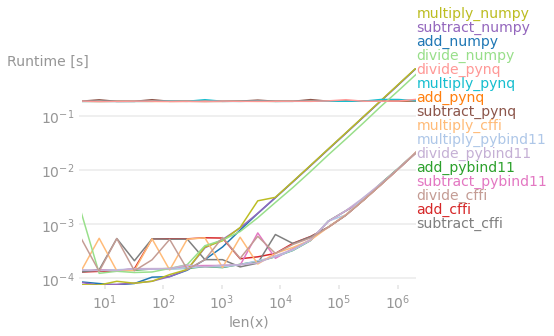

In [9]:
import time
from perfplot._main import PerfplotData

def _setup(n):
    A = allocate(shape=(n,), dtype="i4")
    B = allocate(shape=(n,), dtype="i4")
    C = allocate(shape=(n,), dtype="i4")

    A[:] = np.random.rand(n)
    B[:] = np.random.rand(n)
    C[:] = 0
    
    return A, B, C

kernels = [
    np_add_i4_numpy,
    np_add_i4_pynq,
    np_add_i4_pybind11,
    np_add_i4_cffi,
    np_subtract_i4_numpy,
    np_subtract_i4_pynq,
    np_subtract_i4_pybind11,
    np_subtract_i4_cffi,
    np_multiply_i4_numpy,
    np_multiply_i4_pynq,
    np_multiply_i4_pybind11,
    np_multiply_i4_cffi,
    np_divide_i4_numpy,
    np_divide_i4_pynq,
    np_divide_i4_pybind11,
    np_divide_i4_cffi,
]

iters = 10
n_range = [2 ** k for k in range(2, 22)] 
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)

labels = ["add_numpy", "add_pynq", "add_pybind11", "add_cffi",
          "subtract_numpy", "subtract_pynq", "subtract_pybind11", "subtract_cffi",
          "multiply_numpy", "multiply_pynq", "multiply_pybind11", "multiply_cffi",
          "divide_numpy", "divide_pynq", "divide_pybind11", "divide_cffi"]
xlabel = "len(x)"

for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):        
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        
        print(f"kernel = {j}, n = {n}, t = {timings_s[j,i]}")
        
    for x in data:
        x.freebuffer()
        
p = PerfplotData(
    n_range,
    timings_s,
    None,
    labels,
    xlabel
)

print(p)

p.show()

In [10]:
def export_csv(perf):       
    with open("-".join(perf.labels) + ".csv", "w") as f:
        f.write(",".join(["n"] + perf.labels) + "\n")
        for n, t in zip(perf.n_range, perf.timings_s.T):
            lst = [str(n)] + [str(tt) for tt in t]
            f.write(",".join(lst) + "\n")
            
export_csv(p)